### <span style="font-family: Arial; font-weight:bold;font-size:1.5em;color:#1E90FF"> Recommendation Systems Project<a id='measures'></a>

<span style="font-family: Arial; font-weight:bold;font-size:1.5em;color:#1E905E">Loading Libraries

In [1]:
#Import required libraries

import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import scipy.sparse
from scipy.sparse import csr_matrix

import warnings
warnings.filterwarnings('ignore')


In [2]:
#Import the data set
df_recomm = pd.read_csv('ratings_Electronics.csv', names=['UserId','ProductId','Rating','Timestamp'])

In [3]:
df_recomm.head()

,UserId,ProductId,Rating,Timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [4]:
print(df_recomm.info())
print("\nShape of Data:",df_recomm.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   UserId     object 
 1   ProductId  object 
 2   Rating     float64
 3   Timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB
None

Shape of Data: (7824482, 4)


In [5]:
# Check the number of rows and columns
rows, columns = df_recomm.shape
print("No of rows: ", rows) 
print("No of columns: ", columns) 

No of rows:  7824482
No of columns:  4


In [6]:
df_recomm.drop(['Timestamp'],axis=1,inplace =True)
df_recomm.shape

(7824482, 3)

In [7]:
# Check for missing values 
print('Number of missing values across columns:\n', df_recomm.isnull().sum())

Number of missing values across columns:
 UserId       0
ProductId    0
Rating       0
dtype: int64


#### No missing values with the total records 7824482

In [8]:
# Summary statistics of 'rating' variable
df_recomm['Rating'].describe().transpose()

count    7.824482e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

In [9]:
# find minimum and maximum ratings
print('The minimum rating is: %d' %(df_recomm['Rating'].min()))
print('The maximum rating is: %d' %(df_recomm['Rating'].max()))

The minimum rating is: 1
The maximum rating is: 5


#### Ratings are on scale of 1 - 5

In [10]:
df_recomm["Rating"].value_counts()

5.0    4347541
4.0    1485781
1.0     901765
3.0     633073
2.0     456322
Name: Rating, dtype: int64

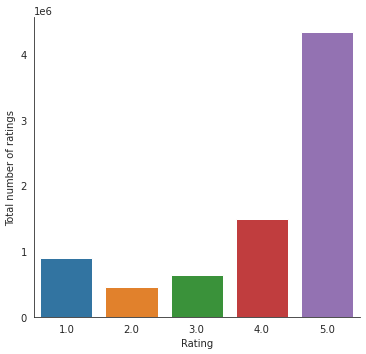

In [11]:
# Check the distribution of ratings 
with sns.axes_style('white'):
    g = sns.factorplot("Rating", data=df_recomm, aspect=1.0,kind='count')
    g.set_ylabels("Total number of ratings") 

##### Spread of the column 'Rating' is not balanced, 5 rating is maximum in count

In [12]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Orginal data = ', df_recomm['UserId'].nunique())
print('Number of unique PRODUCTS in Orginal data = ', df_recomm['ProductId'].nunique())

Number of unique USERS in Orginal data =  4201696
Number of unique PRODUCTS in Orginal data =  476002


In [13]:
# Top 20 users based on rating
most_rated = pd.DataFrame(df_recomm.groupby("UserId")['Rating'].agg(['mean','count']),columns=['mean','count']).sort_values(by=['count','mean'],ascending=False)[:20]
   
most_rated

,mean,count
UserId,,
A5JLAU2ARJ0BO,3.861538,520
ADLVFFE4VBT8,4.283433,501
A3OXHLG6DIBRW8,4.451807,498
A6FIAB28IS79,4.183295,431
A680RUE1FDO8B,4.406404,406
A1ODOGXEYECQQ8,4.305263,380
A36K2N527TXXJN,4.525478,314
A2AY4YUOX2N1BQ,4.559486,311
AWPODHOB4GFWL,4.392857,308


<span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#008000">Take subset of dataset to make it less sparse/more dense. (For example, keep the users only who has given 50 or more number of ratings)

###### <span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#1E90FF"> Filtering users who have rated atleast 50 products

In [14]:
counts = df_recomm['UserId'].value_counts()
df_recomm_final = df_recomm[df_recomm['UserId'].isin(counts[counts >= 50].index)]

In [15]:
print("Total number of users:", df_recomm['UserId'].count())
print('Number of users who have rated 50 or more items =', len(df_recomm_final))
df_recomm_final.shape

Total number of users: 7824482
Number of users who have rated 50 or more items = 125871


(125871, 3)

##### So now in our dataset we only have users who rated atleast 50 products or more.

In [16]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Final data = ', df_recomm_final['UserId'].nunique())
print('Number of unique PRODUCTS in Final data = ', df_recomm_final['ProductId'].nunique())

Number of unique USERS in Final data =  1540
Number of unique PRODUCTS in Final data =  48190


#### Final Distribution Ratings

Final Rating counts :
 5.0    71034
4.0    32295
3.0    12060
2.0     5367
1.0     5115
Name: Rating, dtype: int64


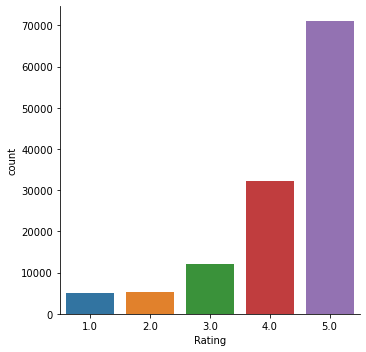

In [17]:
print('Final Rating counts :\n',df_recomm_final["Rating"].value_counts())
sns.catplot(x = "Rating", data=df_recomm_final, kind='count')

In [18]:
df_recomm_final.head()

,UserId,ProductId,Rating
94,A3BY5KCNQZXV5U,0594451647,5.0
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
492,A3CLWR1UUZT6TG,0972683275,5.0


<span style="font-family: Arial; font-weight:bold;font-size:1.5em;color:#1E905E">Split the data set into train and test dataset.

In [19]:
#Split the training and test data in the ratio 70:30
train_data, test_data = train_test_split(df_recomm_final, test_size = 0.3, random_state=0)
train_data.head()

,UserId,ProductId,Rating
6595853,A2BYV7S1QP2YIG,B009EAHVTA,5.0
4738241,AB094YABX21WQ,B0056XCEAA,1.0
4175596,A3D0UM4ZD2CMAW,B004I763AW,5.0
3753016,AATWFX0ZZSE6C,B0040NPHMO,3.0
1734767,A1NNMOD9H36Q8E,B0015VW3BM,4.0


In [20]:
tr_data = train_data.shape
print('Training Dataset shape',tr_data)
tst_data = test_data.shape
print('Testing Dataset shape',test_data.shape)

Training Dataset shape (88109, 3)
Testing Dataset shape (37762, 3)


<span style="font-family: Arial; font-weight:bold;font-size:1.5em;color:#1E905E">Build Popularity Recommender model.

In [21]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped = train_data.groupby('ProductId').agg({'UserId': 'count','Rating':'mean'}).reset_index()
train_data_grouped.rename(columns = {'UserId': 'score','Rating':'mean_value'},inplace=True)
train_data_grouped.head()

,ProductId,score,mean_value
0,0594451647,1,5.0
1,0594481813,1,3.0
2,0970407998,1,1.0
3,0972683275,3,5.0
4,1400501466,4,4.5


In [22]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'ProductId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations 

,ProductId,score,mean_value,Rank
30847,B0088CJT4U,133,4.187970,1.0
30287,B007WTAJTO,124,4.637097,2.0
19647,B003ES5ZUU,122,4.844262,3.0
8752,B000N99BBC,114,4.763158,4.0
30555,B00829THK0,97,4.474227,5.0


In [23]:
#Top products bought have been rated as good on average 
data_prod_rate=pd.DataFrame(df_recomm_final.groupby('ProductId')['Rating'].agg(['mean','count']),
                            columns=['mean','count']).sort_values(by=['count','mean'],ascending=False)[:20]
data_prod_rate.head()

,mean,count
ProductId,,
B0088CJT4U,4.218447,206
B003ES5ZUU,4.864130,184
B000N99BBC,4.772455,167
B007WTAJTO,4.701220,164
B00829TIEK,4.436242,149


In [24]:
# Use popularity based recommender model to make predictions
def Popular_recommend(User_Id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['UserId'] = User_Id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

#### <span style="font-family: Arial; font-weight:bold;font-size:1.5em;color:#1E905E">Top 5 recommendations for different users - Popularity based

In [25]:
find_recom = [102,215,762,1007,1038]   # This list is user choice.
for i in find_recom:
    print("Here is the recommendation for the USERID: %d\n" %(i))
    print(Popular_recommend(i))    
    print("\n") 

Here is the recommendation for the USERID: 102

       UserId   ProductId  score  mean_value  Rank
30847     102  B0088CJT4U    133    4.187970   1.0
30287     102  B007WTAJTO    124    4.637097   2.0
19647     102  B003ES5ZUU    122    4.844262   3.0
8752      102  B000N99BBC    114    4.763158   4.0
30555     102  B00829THK0     97    4.474227   5.0


Here is the recommendation for the USERID: 215

       UserId   ProductId  score  mean_value  Rank
30847     215  B0088CJT4U    133    4.187970   1.0
30287     215  B007WTAJTO    124    4.637097   2.0
19647     215  B003ES5ZUU    122    4.844262   3.0
8752      215  B000N99BBC    114    4.763158   4.0
30555     215  B00829THK0     97    4.474227   5.0


Here is the recommendation for the USERID: 762

       UserId   ProductId  score  mean_value  Rank
30847     762  B0088CJT4U    133    4.187970   1.0
30287     762  B007WTAJTO    124    4.637097   2.0
19647     762  B003ES5ZUU    122    4.844262   3.0
8752      762  B000N99BBC    114    

<span style="font-family: Arial; font-weight:bold;font-size:1.5em;color:#1E905E">Build Collaborative Filtering model.

#### Model-based Collaborative Filtering: Singular Value Decomposition

In [26]:
df_recomm_CF = pd.concat([train_data, test_data]).reset_index()
df_recomm_CF.head()
df_recomm_CF.shape

(125871, 4)

In [27]:
#User-based Collaborative Filtering
# Matrix with row per 'user' and column per 'item' 
pivot_df = df_recomm_CF.pivot(index = 'UserId', columns ='ProductId', values = 'Rating').fillna(0)
pivot_df.shape
pivot_df.head()

ProductId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
UserId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

ProductId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8,user_index
UserId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [29]:
pivot_df.set_index(['user_index'], inplace=True)

# Actual ratings given by users
pivot_df.head()


ProductId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
pivot_df.shape

(1540, 48190)

## SVD method

In [31]:
from scipy.sparse.linalg import svds
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 10)
# Construct diagonal array in SVD
sigma = np.diag(sigma)

In [32]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

ProductId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.002661,0.003576,0.004050,0.006906,0.003967,0.003073,0.005782,0.000568,0.014386,0.002708,...,6.108890e-04,0.044224,0.002919,0.060347,-0.002137,0.006751,0.001525,0.130951,0.059243,0.015014
1,0.002262,0.002505,0.005136,0.016517,0.007120,0.001438,0.013258,0.000335,-0.003781,0.001190,...,2.024793e-04,0.029213,0.000010,0.000244,-0.003111,-0.000621,0.004409,-0.039241,-0.006889,0.003696
2,-0.001600,-0.002502,0.002186,0.016742,0.006716,-0.002113,0.005805,0.003497,-0.005009,-0.001588,...,-3.240446e-04,0.009180,-0.002459,-0.016922,0.019936,-0.002483,-0.000155,-0.002889,-0.011522,-0.004525
3,0.002732,0.003867,0.001799,0.009395,0.004075,0.002778,0.003507,0.000095,0.007983,0.002381,...,6.031462e-04,-0.003369,0.003433,-0.003428,-0.000750,0.000119,0.002612,-0.015107,-0.006740,0.003276
4,0.000704,0.000085,0.002051,0.009664,0.004438,0.000335,0.005992,0.001056,-0.000369,0.000373,...,3.745108e-08,-0.001140,-0.000323,-0.025215,0.004700,-0.002170,0.001263,-0.048555,-0.016301,-0.003377


In [33]:
# Recommend the items with the highest predicted ratings

def recommend_items(UserId, pivot_df, preds_df, num_recommendations):
      
    user_idx = UserId-1 # index starts at 0
    
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    
    #sorted_user_predictions
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

#### Calculate the density of the rating matrix

In [34]:
final_ratings_matrix = df_recomm_final.pivot(index = 'UserId', columns ='ProductId', values = 'Rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('Total number of ratings =', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('Number of possible ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

Shape of final_ratings_matrix:  (1540, 48190)
Total number of ratings = 125871
Number of possible ratings =  74212600
density: 0.17%


#### Evaluation of Model-based Collaborative Filtering (SVD)

In [35]:
# Actual ratings given by the users
final_ratings_matrix.head()

ProductId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
UserId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
 final_ratings_matrix_T = final_ratings_matrix.transpose()
final_ratings_matrix_T.head()

UserId,A100UD67AHFODS,A100WO06OQR8BQ,A105S56ODHGJEK,A105TOJ6LTVMBG,A10AFVU66A79Y1,A10H24TDLK2VDP,A10NMELR4KX0J6,A10O7THJ2O20AG,A10PEXB6XAQ5XF,A10X9ME6R66JDX,...,AYOTEJ617O60K,AYP0YPLSP9ISM,AZ515FFZ7I2P7,AZ8XSDMIX04VJ,AZAC8O310IK4E,AZBXKUH4AIW3X,AZCE11PSTCH1L,AZMY6E8B52L2T,AZNUHQSHZHSUE,AZOK5STV85FBJ
ProductId,,,,,,,,,,,,,,,,,,,,,
0594451647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0594481813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0970407998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0972683275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400501466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

ProductId
0594451647    0.003247
0594481813    0.001948
0970407998    0.003247
0972683275    0.012338
1400501466    0.012987
dtype: float64

In [38]:
# Predicted ratings 
preds_df.head()

ProductId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.002661,0.003576,0.004050,0.006906,0.003967,0.003073,0.005782,0.000568,0.014386,0.002708,...,6.108890e-04,0.044224,0.002919,0.060347,-0.002137,0.006751,0.001525,0.130951,0.059243,0.015014
1,0.002262,0.002505,0.005136,0.016517,0.007120,0.001438,0.013258,0.000335,-0.003781,0.001190,...,2.024793e-04,0.029213,0.000010,0.000244,-0.003111,-0.000621,0.004409,-0.039241,-0.006889,0.003696
2,-0.001600,-0.002502,0.002186,0.016742,0.006716,-0.002113,0.005805,0.003497,-0.005009,-0.001588,...,-3.240446e-04,0.009180,-0.002459,-0.016922,0.019936,-0.002483,-0.000155,-0.002889,-0.011522,-0.004525
3,0.002732,0.003867,0.001799,0.009395,0.004075,0.002778,0.003507,0.000095,0.007983,0.002381,...,6.031462e-04,-0.003369,0.003433,-0.003428,-0.000750,0.000119,0.002612,-0.015107,-0.006740,0.003276
4,0.000704,0.000085,0.002051,0.009664,0.004438,0.000335,0.005992,0.001056,-0.000369,0.000373,...,3.745108e-08,-0.001140,-0.000323,-0.025215,0.004700,-0.002170,0.001263,-0.048555,-0.016301,-0.003377


In [39]:
# Average PREDICTED rating for each item
preds_df.mean().head()

ProductId
0594451647    0.001542
0594481813    0.002341
0970407998    0.002597
0972683275    0.011807
1400501466    0.004848
dtype: float64

In [40]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(48190, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
ProductId,,,
0594451647,0.003247,0.001542,0
0594481813,0.001948,0.002341,1
0970407998,0.003247,0.002597,2
0972683275,0.012338,0.011807,3
1400501466,0.012987,0.004848,4


In [41]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.0033 



#### <span style="font-family: Arial; font-weight:bold;font-size:1.5em;color:#1E905E">Top 5 recommendations for different users - Collaborative based

In [42]:
#Enter 'userID' and 'num_recommendations' for the user #
userID = 102
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 102):

                   user_ratings  user_predictions
Recommended Items                                
B0082E9K7U                  0.0          1.456548
B00ENZRS76                  0.0          1.197721
B007OY5V68                  0.0          1.068893
B004I5FL1G                  0.0          1.047236
B003XE3X8Q                  0.0          1.029943


In [43]:
userID = 215
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 215):

                   user_ratings  user_predictions
Recommended Items                                
B00829TIEK                  0.0          0.996480
B000N99BBC                  0.0          0.935923
B002R5AM7C                  0.0          0.827705
B00829THK0                  0.0          0.801819
B008DWCRQW                  0.0          0.800332


In [44]:
userID = 762
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 762):

                   user_ratings  user_predictions
Recommended Items                                
B0079UAT0A                  0.0          0.796808
B0088CJT4U                  0.0          0.795024
B008DWCRQW                  0.0          0.714603
B004CLYEFK                  0.0          0.684207
B009NHWVIA                  0.0          0.591198


### User-User Collaborative Filtering

In [45]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate

In [46]:
reader = Reader()

In [47]:
data = Dataset.load_from_df(df_recomm_final[['UserId', 'ProductId', 'Rating']], reader)


In [48]:
trainset, testset = train_test_split(data, test_size = 0.30)

In [49]:
User_based_Recommendation = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})


In [50]:
User_based_Recommendation.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [51]:
# we can now query for specific predicions
uid = str(102)  # raw user id
iid = str(302)  # raw item id

In [52]:
# get a prediction for specific users and items.
pred = User_based_Recommendation.predict(uid, iid, verbose=True)

user: 102        item: 302        r_ui = None   est = 4.26   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}


In [53]:
# run the trained model against the testset
test_pred_user = User_based_Recommendation.test(testset)

In [54]:
test_pred_user

[Prediction(uid='A15G70V9OBTOVO', iid='B00894YP00', r_ui=5.0, est=3.8292682926829267, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A1MRPX3RM48T2I', iid='B003WUX6PG', r_ui=5.0, est=4.493975903614458, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A2W9GX82SLKROQ', iid='B0002WPSB2', r_ui=4.0, est=2.7556818181818183, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A25C2M3QF9G7OQ', iid='B00CZDT30S', r_ui=4.0, est=4.80541176330919, details={'actual_k': 4, 'was_impossible': False}),
 Prediction(uid='A1JBEKU5TYIWE7', iid='B001SLFN7U', r_ui=5.0, est=4.5, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A1ILWPH1GHUXE2', iid='B005DKZTLW', r_ui=4.0, est=3.95, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A2JKM8KF3296CW', iid='B004K35GLG', r_ui=4.0, est=4.048780487804878, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A2POXR5VS3PHKR', iid='B001JT1KEG', r_ui=5.0, est=4.260949

In [55]:
# get RMSE
print("User-based Model : Test Set")
accuracy.rmse(test_pred_user, verbose=True)

User-based Model : Test Set
RMSE: 1.0581


1.0580837756958454

### Item-Item Collaborative Filtering

In [56]:
counts = df_recomm_final['UserId'].value_counts()
print('              UserId_counts\n', counts)
df_recomm_l_final = df_recomm_final
df_recomm_final_item = df_recomm_l_final[df_recomm_l_final['UserId'].isin(counts[counts >= 100].index)]
df_recomm_final_item.shape

              UserId_counts
 A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
                 ... 
A3BY5KCNQZXV5U     50
A2RS66Y79Q8X0W     50
A3UW0PQLDUACMH     50
A28CCQNXWV6WA2     50
A1C5TCCR2IGKBU     50
Name: UserId, Length: 1540, dtype: int64


(44209, 3)

In [57]:
data1 = Dataset.load_from_df(df_recomm_final_item[['UserId', 'ProductId', 'Rating']], reader)

In [58]:
trainset, testset = train_test_split(data1, test_size=.30)

In [59]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
Item_based_Recommendation = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': False})
Item_based_Recommendation.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [60]:
# run the trained model against the testset
test_pred_prod = Item_based_Recommendation.test(testset)

In [61]:
test_pred_prod

[Prediction(uid='A1CPRP3VFJRS1R', iid='B005MR50OM', r_ui=4.0, est=4.2853357461384345, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A9Y5O2R4D6EH5', iid='B002DMKPQ2', r_ui=5.0, est=4.0, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A8CKH8XB33XGN', iid='B008CR98SI', r_ui=4.0, est=4.2853357461384345, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A2NOW4U7W3F7RI', iid='B006MA9XXM', r_ui=5.0, est=5, details={'actual_k': 6, 'was_impossible': False}),
 Prediction(uid='A32O5FZH994CNY', iid='B005X9XVNQ', r_ui=4.0, est=3.039428166360162, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid='A3FOSLM5G1BO63', iid='B00AYTW80M', r_ui=3.0, est=3.9731487972531094, details={'actual_k': 4, 'was_impossible': False}),
 Prediction(uid='A1ODOGXEYECQQ8', iid='B00HN2Y2MA', r_ui=4.0, est=5, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='AOEDWQLH2WKKW', iid='B005N

In [62]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred_prod, verbose=True)

Item-based Model : Test Set
RMSE: 1.0942


1.094218063562917

### Alternate subset of the dataset

In [63]:
count_prod = df_recomm_final['ProductId'].value_counts()
df_recomm_final_mean_prod = df_recomm_final[df_recomm_final['ProductId'].isin(count_prod[count_prod >= 2].index)]
df_recomm_final_mean_prod.shape

(95036, 3)

In [64]:
data2 = Dataset.load_from_df(df_recomm_final_mean_prod[['UserId', 'ProductId', 'Rating']], reader)

In [65]:
trainset, testset = train_test_split(data2, test_size=.30)

In [66]:
Item_based_Recommendation = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': False})
Item_based_Recommendation.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [67]:
# run the trained model against the testset
test_pred_prod1 = Item_based_Recommendation.test(testset)

In [68]:
test_pred_prod1

[Prediction(uid='A3QRR8PSCBI07C', iid='B004O0PAKW', r_ui=3.0, est=4.714285714285714, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='AUBEFRFHJR64Y', iid='B0002JFN10', r_ui=3.0, est=4.75, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A3284KYDZ00BZA', iid='B0033PROPS', r_ui=4.0, est=3.0, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A3T4OHEAHOJ700', iid='B004XZHY34', r_ui=5.0, est=4.5112404293351585, details={'actual_k': 4, 'was_impossible': False}),
 Prediction(uid='A1RL1OTV8IJMVD', iid='B00BQHD4B8', r_ui=5.0, est=2.7419182242690585, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid='A1T7EHCMZ92TKC', iid='B001V9KG0I', r_ui=5.0, est=4.8125, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='AFQBS241UKPAZ', iid='B0072DKWQ0', r_ui=4.0, est=4.142857142857143, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A3Q4TYJVAM4IRM', iid='B0007TJ5OG', r_ui=5.0, est=4.666666666666667, d

In [69]:
# get RMSE
print("Item-based Model_1 : Test Set")
accuracy.rmse(test_pred_prod1, verbose=True)

Item-based Model_1 : Test Set
RMSE: 1.1271


1.1270915380606217

<span style="font-family: Arial; font-weight:bold;font-size:1.5em;color:#1E905E">Summarise the insights.